### Guiding Question: What impact does the geographical location of the water body have on the level of contamination (urban vs rural locations)?
#### Hypothesis:
Lakes closer to urban areas (cities and towns) have a higher level of contamination compared to rural locations (villages) due to a higher density of population in urban locations potentially contributing more waste materials in the lakes.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
import descartes
import mapclassify
from mycolorpy import colorlist as mcp
import datetime as dt
%matplotlib inline
mpl.rcParams['figure.dpi']= 96
mpl.style.use('ggplot')
print(gpd.__version__)

import plotly.express as px

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp



0.10.2


### Creating a geopandas dataframe from the dataset

#### Steps:

- Convert the latitude and longitude data to geometry
- Calculate the mean cyanobacterial cell counts aggregated over the entire period from 2014-2020 for each lake
- Create geodataframe from the rsulting dataset of the average cell counts

In [2]:
dataBloom = pd.read_csv('../dataFiles/dataBloom.csv')
dataBloom = dataBloom[(dataBloom.Waterbody_name != 'Mayatan Lake') & (dataBloom.Year != 2021)]
#display(dataBloom.info())

# Get unique values in Month column
print(dataBloom.Month.unique())

# Get counts of entries for each month
countPerMonth = dataBloom.groupby('Month').count()
display(countPerMonth)

# Since majority of data is collected in Months-6, 7, 8 (June, July and August), we will keep data only for these months
#dataBloom = dataBloom[(dataBloom['Month'] >= 6) & (dataBloom['Month'] <= 8)]
#countPerMonth = dataBloom.groupby('Month').count()
#display(countPerMonth)

display(dataBloom.info())

[ 6  7  8  5  9 10  3]


Sample_number  Waterbody_name  Beach_name  Beach_access_num  Latitude  \
Month                                                                          
3                  1               1           1                 1         1   
5                 68              68          68                66        68   
6                569             569         569               545       569   
7                712             712         710               662       712   
8                713             713         713               660       713   
9                 63              63          63                55        63   
10                 5               5           5                 5         5   

       Longitude  Collection_date  Collection_time  MC-LR_conc  \
Month                                                            
3              1                1                1           1   
5             68               68               63          63   
6            569              569              540         548   
7            712              712              687         691   
8            713              713              673         675   
9             63               63               53          59   
10             5                5                5           5   

       Total_cyano_cell_count  ...  Water_description_additional  Turbidity  \
Month                          ...                                            
3                           1  ...                             1          1   
5                          68  ...                            22         52   
6                         569  ...                           156        419   
7                         712  ...                           231        536   
8                         713  ...                           185        521   
9                          63  ...                            17         57   
10                          5  ...                             3          5   

       Color  Water_temp  Wind_direction  Rainfall_24h_bool  Rainfall_24h_mm  \
Month                                                                          
3          1           0               1                  1                1   
5         53          51              53                 51               51   
6        419         401             413                394              372   
7        536         511             534                502              480   
8        523         492             505                507              476   
9         57          57              55                 56               49   
10         5           5               5                  5                5   

       EOB  Year  Day  
Month                  
3        1     1    1  
5       60    68   68  
6      512   569  569  
7      667   712  712  
8      653   713  713  
9       58    63   63  
10       5     5    5  

[7 rows x 24 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 0 to 2130
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sample_number                 2131 non-null   object 
 1   Waterbody_name                2131 non-null   object 
 2   Beach_name                    2129 non-null   object 
 3   Beach_access_num              1994 non-null   float64
 4   Latitude                      2131 non-null   float64
 5   Longitude                     2131 non-null   float64
 6   Collection_date               2131 non-null   object 
 7   Collection_time               2022 non-null   object 
 8   MC-LR_conc                    2042 non-null   object 
 9   Total_cyano_cell_count        2131 non-null   float64
 10  Microcystis_mcyE              1390 non-null   float64
 11  Anabaena_mcyE                 1390 non-null   float64
 12  Planktothrix_mcyE             1390 non-null   float64
 13  Sam

None

In [3]:
# Convert latitude and longitude data to geometry
# Specify crs 
#crs = {'init': 'ESPG:4326'}
crs = u'epsg:'+str(4326)

geometry = [Point(xy) for xy in zip(dataBloom['Longitude'], dataBloom['Latitude'])]
display(len(geometry))
dataBloom['geometry'] = geometry
display(dataBloom.head())

2131

Sample_number    Waterbody_name                    Beach_name  \
0       M141973     Baptiste Lake    Baptiste Lake Public Beach   
1       M141680       Beaver Lake                 Young's Beach   
2       M141971       Bonnie Lake  Bonnie Lake Campground Beach   
3       M141382  Chestermere Lake        Camp Chestermere Beach   
4       M141386  Chestermere Lake        Camp Chestermere Beach   

   Beach_access_num   Latitude   Longitude Collection_date Collection_time  \
0         8830387.0  54.726988 -113.568914      2014-06-24        15:30:00   
1         9621938.0  54.753226 -111.925127      2014-07-29        11:30:00   
2         9013424.0  54.146363 -111.881312      2014-07-25        14:00:00   
3         8805982.0  51.020865 -113.818185      2014-06-04        15:00:00   
4         8805982.0  51.020865 -113.818185      2014-06-11        13:30:00   

  MC-LR_conc  Total_cyano_cell_count  ...  Color  Water_temp  Wind_direction  \
0        NaN                532110.0  ...  Green        20.2              NE   
1       0.52               1793582.0  ...    NaN         NaN             NaN   
2       0.07                     0.0  ...    NaN         NaN             NaN   
3      <0.05                     0.0  ...    NaN         NaN             NaN   
4      <0.05                     0.0  ...    NaN         NaN             NaN   

  Rainfall_24h_bool Rainfall_24h_mm                     EOB  Year  Month Day  \
0              True             NaN  streaks on the surface  2014      6  24   
1               NaN             NaN  streaks on the surface  2014      7  29   
2               NaN             NaN  streaks on the surface  2014      7  25   
3               NaN             NaN            not apparent  2014      6   4   
4               NaN             NaN            not apparent  2014      6  11   

                        geometry  
0  POINT (-113.568914 54.726988)  
1  POINT (-111.925127 54.753226)  
2  POINT (-111.881312 54.146363)  
3  POINT (-113.818185 51.020865)  
4  POINT (-113.818185 51.020865)  

[5 rows x 26 columns]

We will use the year 2016 as an example to plot the mean cyanobacterial cell count for each waterbody along with the Alberta cities, towns and villages on the munipality map. 

- For the main analysis, we will use some criteria toselect the year for comparison of different lakes in terms of their cyanobacterial counts and their proximity to cities, towns or villages. 
- Need to figure out a way to calculate the distance of the lakes from the nearest city, town and village for a more quantitative measure of the correlation between cyanobacterial counts and the proximities to these municipalities. Luckily, geo pandas has a way to make such distance calculations. 


In [4]:
# Average Total_cyano_cell_count data aggregated over the entire period
avgCellCounts = dataBloom[['Waterbody_name', 'geometry', 'Total_cyano_cell_count']].groupby('Waterbody_name').agg({'Total_cyano_cell_count':'mean',
                                                                               'geometry': 'first'}, skipna = True).sort_values('Total_cyano_cell_count', ascending=False).reset_index()
print(len(avgCellCounts))
display(avgCellCounts[:50])


97


Waterbody_name  Total_cyano_cell_count  \
0               Bullshead Reservoir            3.381348e+06   
1           Acadia Valley Reservoir            2.523260e+06   
2                       Beaver Lake            1.793582e+06   
3               Steele (Cross) Lake            1.707050e+06   
4                     Skeleton Lake            1.115749e+06   
5             Berry Creek Reservoir            1.107953e+06   
6     Devil's Lake (Matchayaw Lake)            1.037448e+06   
7        Milk River Ridge Reservoir            9.108355e+05   
8                     Lac Ste. Anne            6.346510e+05   
9                      Lessard Lake            5.756717e+05   
10                      Bonnie Lake            5.602454e+05   
11              Stoney (Siler) Lake            5.475614e+05   
12                     Wabamun Lake            5.143830e+05   
13                   Half Moon Lake            4.976112e+05   
14                    Hastings Lake            4.765210e+05   
15                   Chickakoo Lake            4.139780e+05   
16                      Garner Lake            3.862235e+05   
17                       Eagle Lake            3.730237e+05   
18                       Smoke Lake            3.720424e+05   
19                     Thunder Lake            3.467039e+05   
20                        Fork Lake            3.065690e+05   
21                      Muriel Lake            2.942700e+05   
22                      Pigeon Lake            2.927446e+05   
23                     Laurier Lake            2.894510e+05   
24            Reesor Lake Reservoir            2.550530e+05   
25           Severn Creek Reservoir            2.519356e+05   
26                     Lac La Nonne            2.515535e+05   
27                       Goose Lake            2.477826e+05   
28                      Wizard Lake            2.378136e+05   
29                        Isle Lake            2.297043e+05   
30                        Gull Lake            2.241016e+05   
31                      Murray Lake            2.184510e+05   
32                     Kehiwin Lake            2.129470e+05   
33                  North Buck Lake            1.967564e+05   
34                        Buck Lake            1.963000e+05   
35        Jackfish Lake (Athabasca)            1.803274e+05   
36                        Pine Lake            1.740436e+05   
37                        Lac Sante            1.739450e+05   
38                    Baptiste Lake            1.695846e+05   
39                      Sylvan Lake            1.610163e+05   
40                        Mink Lake            1.598804e+05   
41                       Hasse Lake            1.466158e+05   
42                       Bangs Lake            1.445805e+05   
43                      Peanut Lake            1.376100e+05   
44                      Minnie Lake            1.325824e+05   
45  Jackfish Lake (Parkland County)            1.300966e+05   
46                        Long Lake            1.286568e+05   
47                     Lac La Biche            1.268547e+05   
48               Floatingstone Lake            1.248513e+05   
49                    Lake McGregor            1.217503e+05   

                                geometry  
0   POINT (-110.516857259 49.6778870436)  
1          POINT (-110.256959 51.099371)  
2          POINT (-111.925127 54.753226)  
3          POINT (-113.794963 54.652335)  
4           POINT (-112.726508 54.61404)  
5          POINT (-111.635259 51.258069)  
6          POINT (-114.093919 53.714757)  
7          POINT (-112.556819 49.363377)  
8          POINT (-114.493872 53.702638)  
9           POINT (-114.65562 53.777495)  
10         POINT (-111.881312 54.146363)  
11         POINT (-111.082565 53.865406)  
12         POINT (-114.634589 53.568609)  
13         POINT (-113.083959 53.456039)  
14         POINT (-112.908238 53.417176)  
15         POINT (-114.071815 53.615789)  
16          POINT (-111.73274 54.181109)  
17         POINT (-113.291621 50.

In [5]:
# Create geodataframe from the dataset
geo_df_CellCounts = gpd.GeoDataFrame(avgCellCounts, # specify dataset
                         crs = crs, # Specify our coordinate reference system
                         geometry = avgCellCounts['geometry']) # Specify the geometry list created
                          
display(geo_df_CellCounts.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Waterbody_name          97 non-null     object  
 1   Total_cyano_cell_count  97 non-null     float64 
 2   geometry                97 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 2.4+ KB


None

### Visualize Alberta's lake data over the basemap of Alberta's geometric entities colormapped by City or Town or Village boundaries and the mean cyanobacterial cell counts

#### Steps:

- Read shape files for Alberta's municipality boundaries and the City/Town/Village boundaries
- Plot the geodataframe over the basemap and split the mean cell counts into 6 quantiles


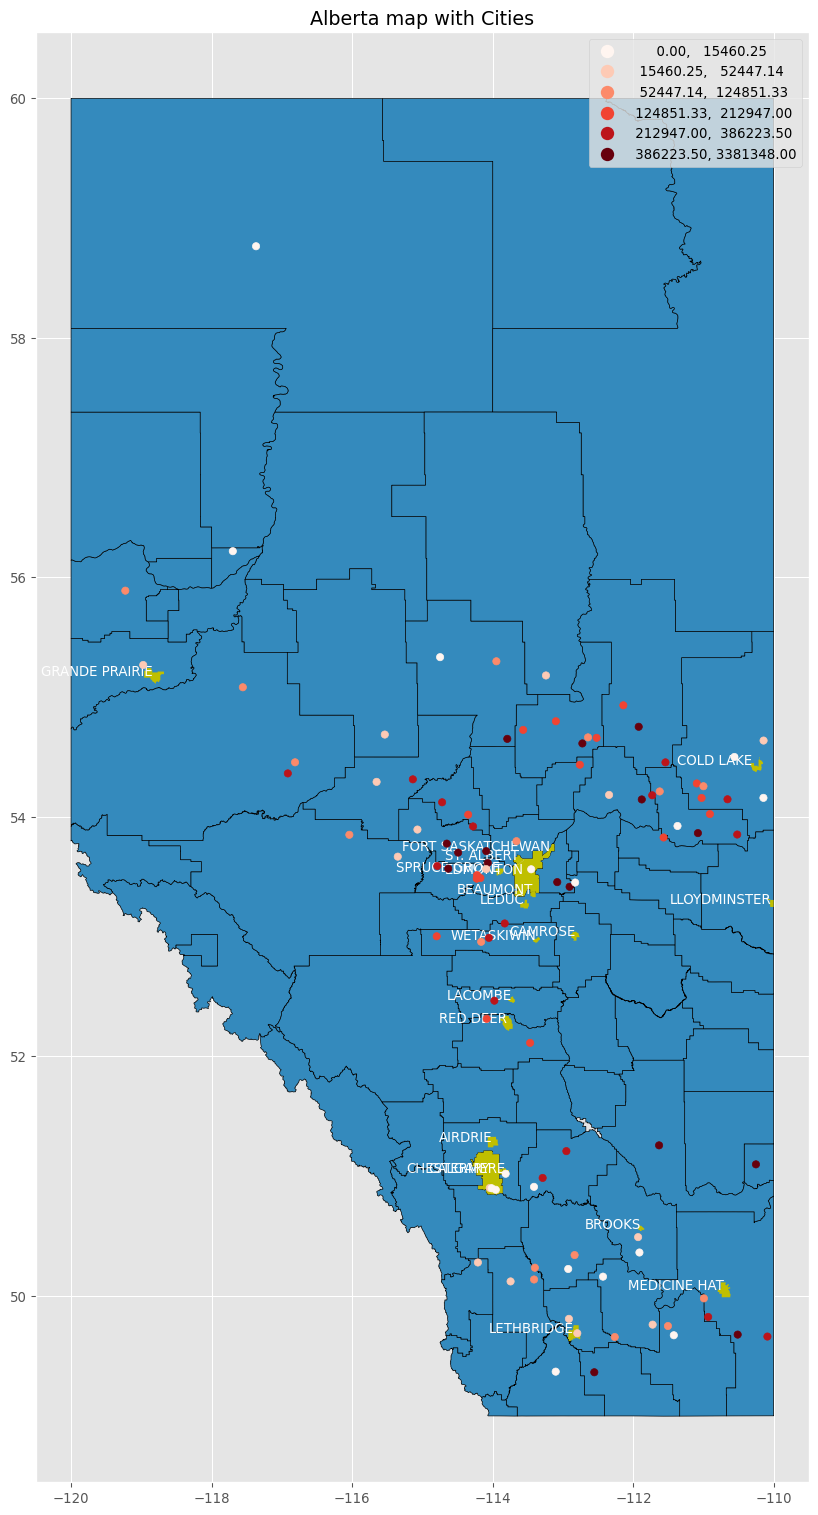

In [9]:
# Read shape file for Alberta city boundary
city_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/CITY.shp')
city_map['coords'] = city_map['geometry'].apply(lambda x: x.representative_point().coords[:])
city_map['coords'] = [coords[0] for coords in city_map['coords']]
rural_municipality_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/RURAL.shp')
town_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/TOWN.shp')
village_map =  gpd.read_file('../Municipal_Boundaries_SHP_Geographic/VILLAGE.shp')
SVillage_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/SVILLAGE.shp')
urban_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/urbserv.shp')


#display(rural_municipality_map.info())

fig, ax = plt.subplots(figsize= (15,15))
#ax.text(0.1, 0.9, 'text', ha='center', va='center',fontsize=10)
rural_municipality_map.plot(ax=ax, edgecolor='black', zorder=1)
p1 = city_map.plot(ax=ax, color='y', label='city')
for idx, row in city_map.iterrows():
    plt.annotate(text=row['GEONAME'][8:], xy=row['coords'],
                 horizontalalignment='right', fontsize=10, color='w', zorder=2)
#p2 = town_map.plot(ax=ax, color='k', label='town')
#p3 = village_map.plot(ax=ax, color='b', label='village')



geo_df_CellCounts.plot(ax=ax, column='Total_cyano_cell_count', 
                         scheme='quantiles', k=6, cmap='Reds', legend=True, markersize=30, zorder=3)


ax.set_title('Alberta map with Cities')
fig.set_size_inches(20,20)


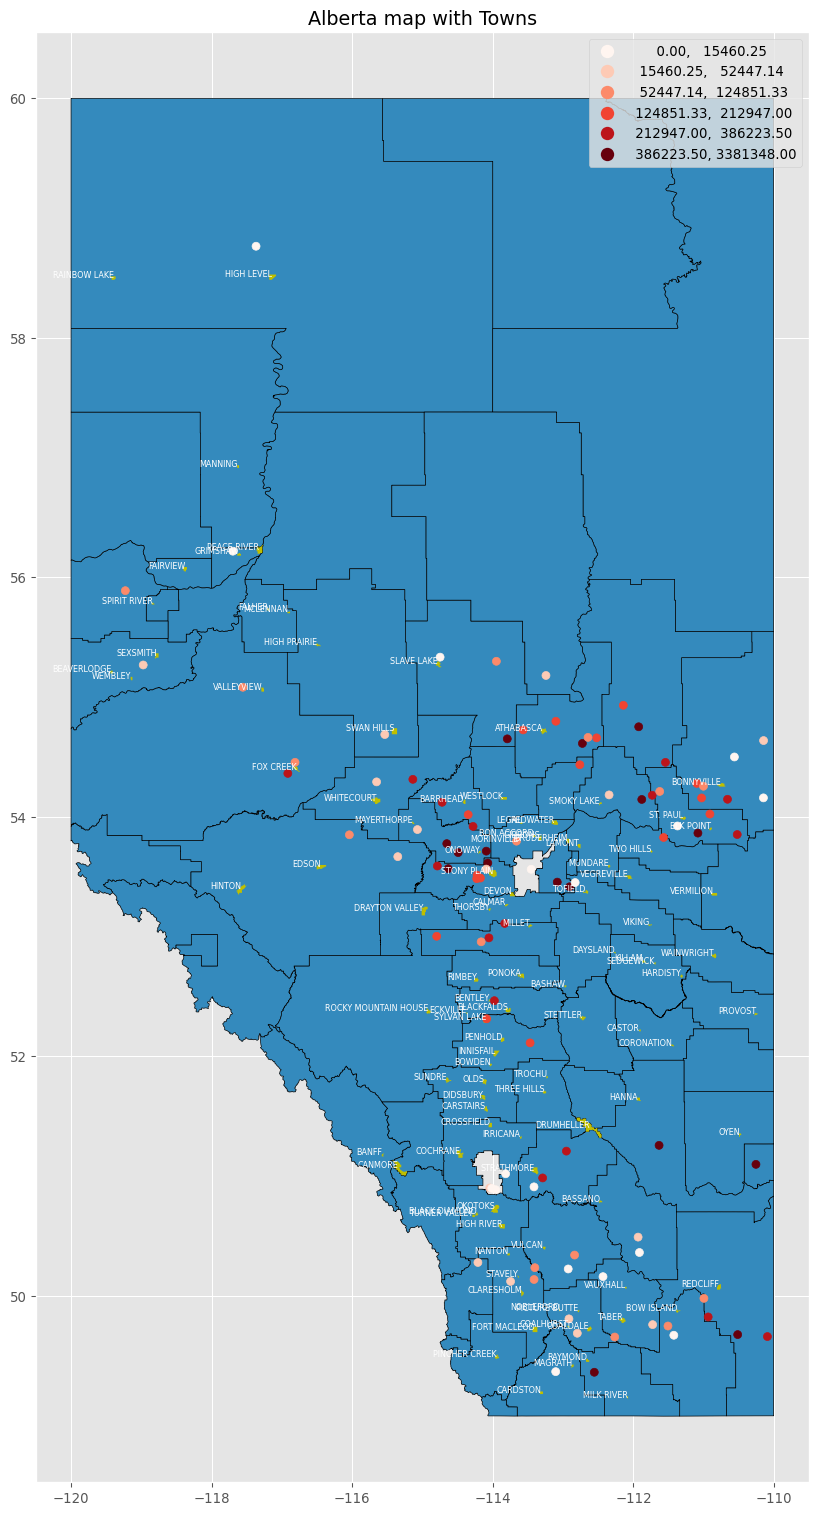

In [10]:
town_map = gpd.read_file('../Municipal_Boundaries_SHP_Geographic/TOWN.shp')
town_map['coords'] = town_map['geometry'].apply(lambda x: x.representative_point().coords[:])
town_map['coords'] = [coords[0] for coords in town_map['coords']]
fig, ax = plt.subplots(figsize= (15,15))
#ax.text(0.1, 0.9, 'text', ha='center', va='center',fontsize=10)
rural_municipality_map.plot(ax=ax, edgecolor='black')

p2 = town_map.plot(ax=ax, color='y', label='town')
for idx, row in town_map.iterrows():
    plt.annotate(text=row['GEONAME'][8:], xy=row['coords'],
                 horizontalalignment='right', fontsize=6, color='w')


geo_df_CellCounts.plot(ax=ax, column='Total_cyano_cell_count', 
                         scheme='quantiles', k=6, cmap='Reds', legend=True)

ax.set_title('Alberta map with Towns')
fig.set_size_inches(20,20)

Further Refining Steps:
1. Plot the statistics of cyanobacterial counts for all lakes aggregated over the years. This will show the distribution of the feature over the years 

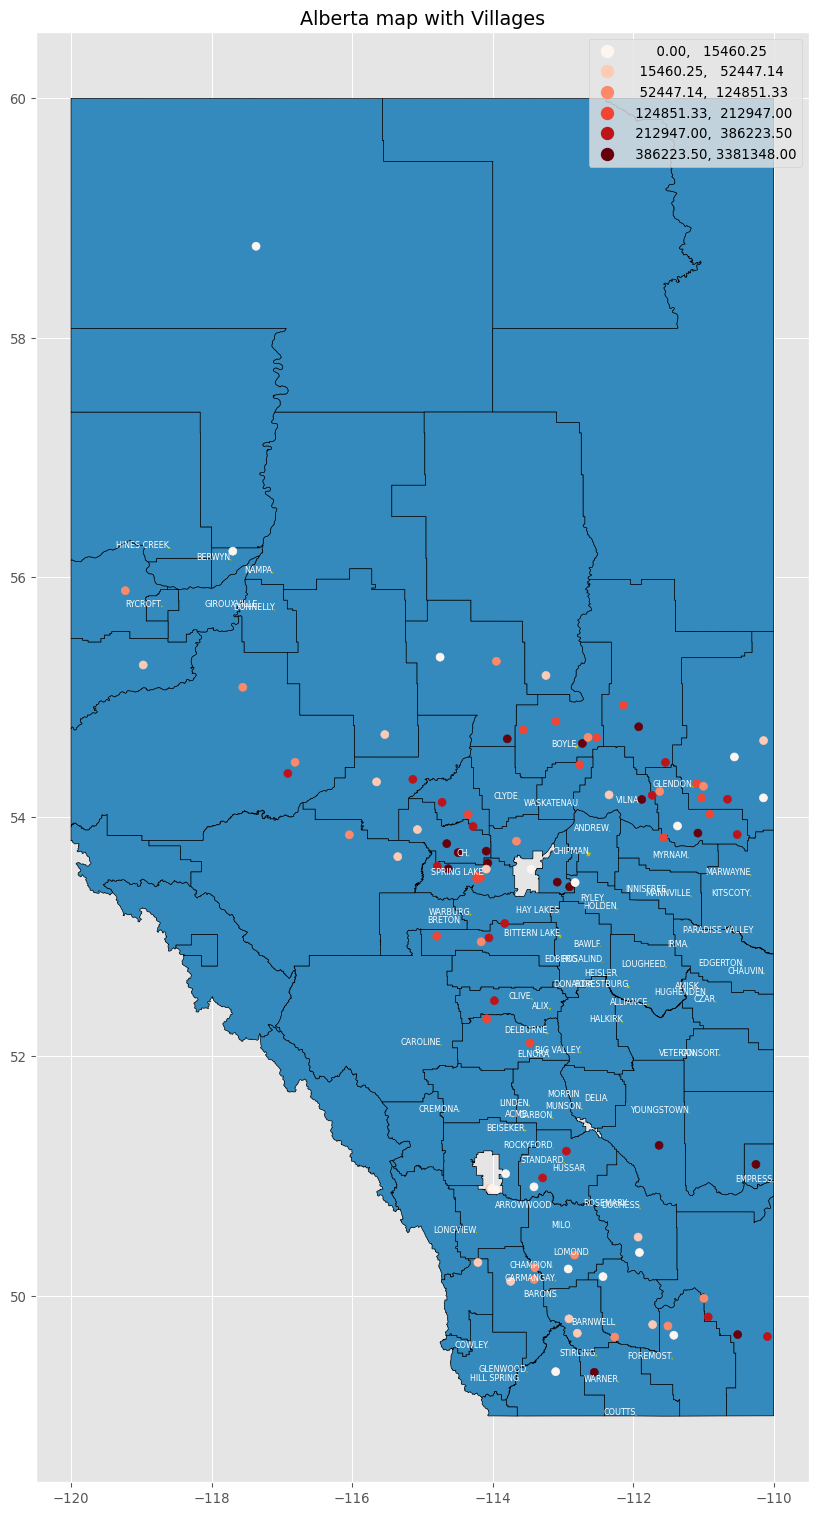

In [11]:
village_map =  gpd.read_file('../Municipal_Boundaries_SHP_Geographic/VILLAGE.shp')
village_map['coords'] = village_map['geometry'].apply(lambda x: x.representative_point().coords[:])
village_map['coords'] = [coords[0] for coords in village_map['coords']]

fig, ax = plt.subplots(figsize= (15,15))
#ax.text(0.1, 0.9, 'text', ha='center', va='center',fontsize=10)
rural_municipality_map.plot(ax=ax, edgecolor='black')
p3 = village_map.plot(ax=ax, color='y', label='village')
for idx, row in village_map.iterrows():
    plt.annotate(text=row['GEONAME'][11:], xy=row['coords'],
                 horizontalalignment='right', fontsize=6, color='w')




geo_df_CellCounts.plot(ax=ax, column='Total_cyano_cell_count', 
                         scheme='quantiles', k=6, cmap='Reds', legend=True)

#ax.legend(reversed(handles), labels, title='Boundary', loc='upper left')
ax.set_title('Alberta map with Villages')
fig.set_size_inches(20,20)

### Determine whether proximity to a city, town, or village is related to the cyanobacterial contamination in the lakes

#### Steps:

#### Data Wrangling
- Determine the distance (in meters) of each lake to Alberta's cities, towns and villages
- Find the closest city, town and village to each lake and record the distance in a dataframe
- Create a new dataframe for the closest municipality type (city or town or village) to each lake

#### Analysis
- Boxplot for the mean cyanobacterial cell counts Vs the closest municipality type
- Histogram and QQ plot to check the distribution of data
- One-way Anova with appropriate posthoc test for multiple comparisons
- Scatterplots for cyanobacterial counts and distances to cities/towns/villages with correlation coefficients

In [12]:
# convert to world mercator which has units of meters
# https://epsg.io/3395
geo_df_CellCounts.geometry = geo_df_CellCounts.geometry.to_crs(epsg=3395)
city_map.geometry = city_map.geometry.to_crs(3395)
town_map.geometry = town_map.geometry.to_crs(3395)
village_map.geometry = village_map.geometry.to_crs(3395)

# Calculate distance of each waterbody to the cities in Alberta and find the nearest city
distToCities = geo_df_CellCounts.geometry.apply(lambda g: city_map.distance(g)).reset_index()

distToCities.columns = ['Waterbody_name'] + list(city_map['GEONAME'])
distToCities['Waterbody_name'] = geo_df_CellCounts['Waterbody_name']
distToCities = distToCities.melt(id_vars = ['Waterbody_name'], var_name = 'City', value_name='CityDistance')
display(len(distToCities))
nearestCityDist = distToCities.loc[distToCities.groupby('Waterbody_name')['CityDistance'].idxmin()]
display(len(nearestCityDist))

# Calculate distance of each waterbody to the Towns in Alberta and fine the nearest town
distToTowns = geo_df_CellCounts.geometry.apply(lambda g: town_map.distance(g)).reset_index()
distToTowns.columns = ['Waterbody_name'] + list(town_map['GEONAME'])
distToTowns['Waterbody_name'] = geo_df_CellCounts['Waterbody_name']
#display(distToTowns)
distToTowns = distToTowns.melt(id_vars = ['Waterbody_name'], var_name = 'Town', value_name='TownDistance')
nearestTownDist = distToTowns.loc[distToTowns.groupby('Waterbody_name')['TownDistance'].idxmin()]
display(len(nearestTownDist))

# Calculate distance of each waterbody to the Villages in Alberta and find the nearest village
distToVillages = geo_df_CellCounts.geometry.apply(lambda g: village_map.distance(g)).reset_index()
distToVillages.columns = ['Waterbody_name'] + list(village_map['GEONAME'])
distToVillages['Waterbody_name'] = geo_df_CellCounts['Waterbody_name']
#display(distToVillages)
distToVillages = distToVillages.melt(id_vars = ['Waterbody_name'], var_name = 'Village', value_name='VillageDistance')
nearestVillageDist = distToVillages.loc[distToVillages.groupby('Waterbody_name')['VillageDistance'].idxmin()]
display(len(nearestVillageDist))


1843

97

97

97

In [13]:
# Combine the datasets for the distances with the mean cyanobacterial counts for each lake

dfCountVsDist = avgCellCounts[['Waterbody_name', 'Total_cyano_cell_count']].merge(nearestCityDist, how='outer', on = 'Waterbody_name').merge(nearestTownDist, how='outer', on = 'Waterbody_name').merge(nearestVillageDist, how='outer', on = 'Waterbody_name')
display(dfCountVsDist)
dfCountVsNearest = dfCountVsDist.drop(columns = ['City', 'Town', 'Village']).rename(columns = {'CityDistance':'City',
                                                                                              'TownDistance': 'Town',
                                                                                              'VillageDistance': 'Village'})
display(dfCountVsNearest.sort_values('Total_cyano_cell_count')[40:])
dfCountVsNearest = dfCountVsNearest.melt(id_vars = ['Waterbody_name', 'Total_cyano_cell_count'], var_name = 'NearestMunicipality', value_name='Distance')
dfCountVsNearest = dfCountVsNearest.loc[dfCountVsNearest.groupby('Waterbody_name')['Distance'].idxmin()]
display(dfCountVsNearest)

fig = px.box(dfCountVsNearest, x='NearestMunicipality', y ='Total_cyano_cell_count',
            hover_data=dfCountVsNearest.columns,
            labels = {
                'NearestMunicipality': 'Nearest Municipality'
            })

fig.show()

# Identify outliers
outliers = ['Acadia Valley Reservoir', 'Beaver Lake', 'Skeleton Lake', 
            'Steele (Cross) Lake', 'Devil\'s Lake (Matchayaw Lake)', 
            'Milk River Ridge Reservoir', 'Half Moon Lake', 'Bullshead Reservoir']



Waterbody_name  Total_cyano_cell_count  \
0        Bullshead Reservoir            3.381348e+06   
1    Acadia Valley Reservoir            2.523260e+06   
2                Beaver Lake            1.793582e+06   
3        Steele (Cross) Lake            1.707050e+06   
4              Skeleton Lake            1.115749e+06   
..                       ...                     ...   
92          Chestermere Lake            5.184878e+02   
93               Sikome Lake            0.000000e+00   
94  Lac Cardinal (Bear Lake)            0.000000e+00   
95        Crane (Moore) Lake            0.000000e+00   
96        Lower Thérien Lake            0.000000e+00   

                         City   CityDistance                Town  \
0        CITY OF MEDICINE HAT   54845.797563    TOWN OF REDCLIFF   
1        CITY OF MEDICINE HAT  179080.387461        TOWN OF OYEN   
2           CITY OF COLD LAKE  186541.846051  TOWN OF SMOKY LAKE   
3   CITY OF FORT SASKATCHEWAN  181328.953427   TOWN OF ATHABASCA   
4   CITY OF FORT SASKATCHEWAN  165448.845379   TOWN OF ATHABASCA   
..                        ...            ...                 ...   
92        CITY OF CHESTERMERE       0.000000  TOWN OF STRATHMORE   
93            CITY OF CALGARY       0.000000     TOWN OF OKOTOKS   
94     CITY OF GRANDE PRAIRIE  226245.357233    TOWN OF GRIMSHAW   
95          CITY OF COLD LAKE   27477.513635  TOWN OF BONNYVILLE   
96          CITY OF COLD LAKE  148124.847639    TOWN OF ST. PAUL   

     TownDistance              Village  VillageDistance  
0    69716.855390  VILLAGE OF FOREMOST    107743.979933  
1    48003.873852   VILLAGE OF EMPRESS     35244.015605  
2   133948.247037     VILLAGE OF BOYLE     99886.906749  
3    53974.421365     VILLAGE OF CLYDE     96446.960508  
4    59070.718867     VILLAGE OF BOYLE      6767.522817  
..            ...                  ...              ...  
92   41432.145589  VILLAGE OF BEISEKER     68850.880648  
93   24980.573442  VILLAGE OF LONGVIEW     67957.953609  
94    8351.259608    VILLAGE OF BERWYN     13755.015302  
95   45008.611324   VILLAGE OF GLENDON     79818.970700  
96   11597.352921    VILLAGE OF MYRNAM     50916.106795  

[97 rows x 8 columns]

Waterbody_name  Total_cyano_cell_count           City  \
56                       Clear Lake            7.736308e+04   90768.668479   
55                      Yellow Lake            8.131550e+04   92761.767203   
54                      Battle Lake            8.666400e+04   81365.173544   
53                        Hope Lake            9.087831e+04  177309.131036   
52            Twin Valley Reservoir            9.163772e+04  103175.733567   
51                    Sturgeon Lake            1.070546e+05  126702.316096   
50                       Moose Lake            1.088127e+05   81489.748631   
49                    Lake McGregor            1.217503e+05  101264.660062   
48               Floatingstone Lake            1.248513e+05  149642.282610   
47                     Lac La Biche            1.268547e+05  221889.235863   
46                        Long Lake            1.286568e+05  131686.110127   
45  Jackfish Lake (Parkland County)            1.300966e+05   31832.562604   
44                      Minnie Lake            1.325824e+05   89741.043487   
43                      Peanut Lake            1.376100e+05   95338.189685   
42                       Bangs Lake            1.445805e+05   91902.074088   
41                       Hasse Lake            1.466158e+05   25976.323205   
40                        Mink Lake            1.598804e+05   30050.799507   
39                      Sylvan Lake            1.610163e+05   21191.555653   
38                    Baptiste Lake            1.695846e+05  186865.404766   
37                        Lac Sante            1.739450e+05  173223.768774   
36                        Pine Lake            1.740436e+05   34820.983834   
35        Jackfish Lake (Athabasca)            1.803274e+05  195043.547985   
34                        Buck Lake            1.963000e+05  133830.999275   
33                  North Buck Lake            1.967564e+05  181147.583593   
32                     Kehiwin Lake            2.129470e+05   96986.381150   
31                      Murray Lake            2.184510e+05   35529.163362   
30                        Gull Lake            2.241016e+05   21876.535648   
29                        Isle Lake            2.297043e+05   92600.332506   
28                      Wizard Lake            2.378136e+05   34716.361432   
27                       Goose Lake            2.477826e+05  192457.303948   
26                     Lac La Nonne            2.515535e+05   75342.923136   
25           Severn Creek Reservoir            2.519356e+05   95243.666456   
24            Reesor Lake Reservoir            2.550530e+05   81313.723206   
23                     Laurier Lake            2.894510e+05  103005.017693   
22                      Pigeon Lake            2.927446e+05   68161.707323   
21                      Muriel Lake            2.942700e+05   60851.104221   
20                        Fork Lake            3.065690e+05  134859.427337   
19                     Thunder Lake            3.467039e+05  134534.831232   
18                       Smoke Lake            3.720424e+05  251316.622225   
17                       Eagle Lake            3.730237e+05   54277.678062   
16                      Garner Lake            3.862235e+05  162748.760536   
15                   Chickakoo Lake            4.139780e+05   15357.795165   
14                    Hastings Lake            4.765210e+05   48579.724155   
13                   Half Moon Lake            4.976112e+05   28978.730999   
12                     Wabamun Lake            5.143830e+05   75198.258996   
11              Stoney (Siler) Lake            5.475614e+05  131880.387252   
10                      Bonnie Lake            5.602454e+05  155176.749693   
9                      Lessard Lake            5.756717e+05   86877.655851   
8                     Lac Ste. Anne            6.346510e+05   64619.374977   
7        Milk River Ridge Reservoir            9.108355e+05   52225.131559   
6     Devil's Lake (Matchayaw Lake)        

Waterbody_name  Total_cyano_cell_count NearestMunicipality  \
195  Acadia Valley Reservoir            2.523260e+06             Village   
88                Auburn Bay            4.722500e+03                City   
236               Bangs Lake            1.445805e+05             Village   
135            Baptiste Lake            1.695846e+05                Town   
248              Battle Lake            8.666400e+04             Village   
..                       ...                     ...                 ...   
283        Travers Reservoir            4.182521e+03             Village   
246    Twin Valley Reservoir            9.163772e+04             Village   
206             Wabamun Lake            5.143830e+05             Village   
125              Wizard Lake            2.378136e+05                Town   
152              Yellow Lake            8.131550e+04                Town   

         Distance  
195  35244.015605  
88       0.000000  
236  20676.754512  
135  27564.843029  
248  42967.442398  
..            ...  
283  23976.191244  
246  27604.376675  
206  34585.049229  
125  26545.180424  
152  23507.114417  

[97 rows x 4 columns]

### Statistical Analysis of Mean Cyanobacterial Counts vs Nearest Municipality Type

In [14]:
# Pie chart for the counts of municipality types nearest to the lakes
fig = px.pie(dfCountVsNearest, 'NearestMunicipality',
            hover_name='Waterbody_name',
            title='Nearest Municipalities to Alberta Lakes')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

C:\Users\radhi\anaconda3\lib\site-packages\bioinfokit\analys.py:365: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



group1 group2           Diff          Lower          Upper   q-value  \
0  Village   City  116754.305333 -249262.115630  482770.726296  1.074336   
1  Village   Town  179494.399846  -98830.053985  457818.853677  2.172037   
2     City   Town   62740.094513 -278637.273739  404117.462765  0.618982   

    p-value  
0  0.710319  
1  0.279360  
2  0.893704

C:\Users\radhi\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



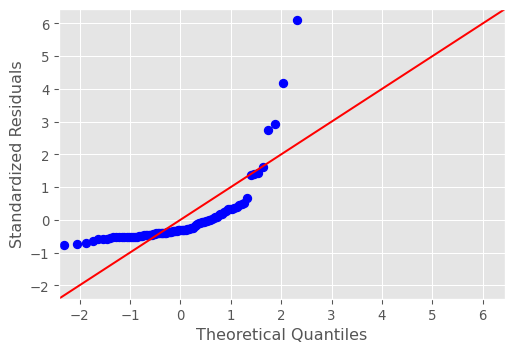

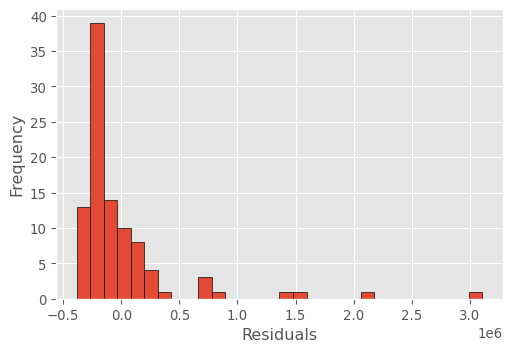

In [15]:
# Perform ANOVA
df = dfCountVsNearest[['Waterbody_name', 'NearestMunicipality', 'Total_cyano_cell_count']].pivot(index='Waterbody_name', 
                                                                                                columns='NearestMunicipality',
                                                                                                values='Total_cyano_cell_count')
#display(df)

df = dfCountVsNearest[['Waterbody_name', 'NearestMunicipality', 'Total_cyano_cell_count']].set_index('Waterbody_name')
#print(df)
res = stat()
# for main effect Genotype
res.tukey_hsd(df=df, res_var='Total_cyano_cell_count', xfac_var='NearestMunicipality', anova_model='Total_cyano_cell_count~C(NearestMunicipality)')
display(res.tukey_summary)


# QQ-plot
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()


In [16]:
# Perform Kruskall-Wallis test
df = dfCountVsNearest[['Waterbody_name', 'NearestMunicipality', 'Total_cyano_cell_count']].pivot(index='Waterbody_name', 
                                                                                                columns='NearestMunicipality',
                                                                                                values='Total_cyano_cell_count')
#display(df)
stats.kruskal(df['City'], df['Town'], df['Village'], nan_policy='omit')

# Posthoc test
df = dfCountVsNearest[['Waterbody_name', 'NearestMunicipality', 'Total_cyano_cell_count']].set_index('Waterbody_name')
#print(df)
sp.posthoc_dunn(df, val_col='Total_cyano_cell_count', group_col='NearestMunicipality', p_adjust = 'holm')


City      Town   Village
City     1.000000  0.074919  0.001788
Town     0.074919  1.000000  0.074919
Village  0.001788  0.074919  1.000000

Correlations between distance to the nearest village and mean cyanobacterial counts for the lakes

In [17]:
# Data after removing outliers
data = dfCountVsDist[~dfCountVsDist['Waterbody_name'].isin(outliers)]

# Scatterplot for Villages
## Correlation Coefficient
corr = stats.spearmanr(data['VillageDistance'], data['Total_cyano_cell_count'])

fig = px.scatter(data, x='VillageDistance', y='Total_cyano_cell_count', trendline="ols",
                hover_name='Waterbody_name',
                 labels={
                     "VillageDistance": "Distance to the Nearest Village",
                     "Total_cyano_cell_count": "Mean Cyanobacterial Cell Count (cells/ml)",
                 })
                
# add annotation
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.6,
                                        y=0.9,
                                        showarrow=False,
                                        text= "Spearman's rho: " + str(round(corr[0], 2)) +"\nPVal: " + str(round(corr[1], 2)),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.show()


# Scatterplot for 
corr = stats.spearmanr(data['TownDistance'], data['Total_cyano_cell_count'])
fig = px.scatter(data, x='TownDistance', y='Total_cyano_cell_count', trendline="ols",
                hover_name='Waterbody_name',
                 labels={
                     "VillageDistance": "Distance to the Nearest Town",
                     "Total_cyano_cell_count": "Mean Cyanobacterial Cell Count (cells/ml)",
                 })
# add annotation
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.6,
                                        y=0.9,
                                        showarrow=False,
                                        text= "Spearman's rho: " + str(round(corr[0], 2)) +"\nPVal: " + str(round(corr[1], 2)),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()

# Scatterplot for Cities
corr = stats.spearmanr(data['CityDistance'], data['Total_cyano_cell_count'])
fig = px.scatter(data, x='CityDistance', y='Total_cyano_cell_count', trendline="ols",
                hover_name='Waterbody_name',
                 labels={
                     "VillageDistance": "Distance to the Nearest City",
                     "Total_cyano_cell_count": "Mean Cyanobacterial Cell Count (cells/ml)",
                 })
# add annotation
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.6,
                                        y=0.9,
                                        showarrow=False,
                                        text= "Spearman's rho: " + str(round(corr[0], 2)) +"\nPVal: " + str(round(corr[1], 2)),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()

#### Conclusion
The results from this section reject our hypothesis that lakes closer to cities and towns tend to be more contaminated with cyanobacteria than the lakes closer to rural areas.

There are several factors that contribute to nutrient enrichment (or eutrophication) of lakes, which is a top cause of cyanobacterial contamination of water. These include industrial effluents, failure of septic tanks, atmospheric deposition of nutrients, agricultural runoff, and recreational activity among others.

A potential reason for the increased contamination observed in lakes closer to villages is the agriculture and animal husbandry practices in villages that dump large amounts of nitrogen and phosphorus rich nutrients into waste water and irrigation run-off.